Simulation of a passive circle inmersed in a bath of bacteria with a velocity gradient along the simulation box.

The interactions between the cells and the passive sphere assume that, when colliding, the cells push the sphere with the drag force $F=\gamma v$, where $\gamma_i=6\pi\eta R_i$ is the drag coefficient and $\eta=10^{-3}$Pa·s is the viscosity of the medium (water).

A few of things to note:
- I assume the passive circle does not present Brownian motion
- The interactions do not work in the boundaries (PBC are not applied to interactions)
- I assume that $\gamma_{bacteria}+\gamma_{circle} \approx \gamma_{circle}$ ($\gamma_{circle}>>\gamma_{bacteria}$)
- Sometimes the bacteria go through the sphere (to fix..)

In [58]:
from pylab import *
from scipy.optimize import curve_fit
%matplotlib inline
warnings.filterwarnings("ignore")

## Input parameters:

In [107]:
#BACTERIA:
N = 10000
v0 = 1. #um/s
lam = 1. #s^-1
Rb=0.5 #um

#BOX (Square simulation box)
L = 300 #um 

#viscosity (of water)
eta=0.001 #Pa*s

# Time step in seconds
dt = 0.1 #s

#Passive circle
R=10. #um

#drag coefficients:
gamma_circle=6*pi*eta*R
gamma_bacteria=6*pi*eta*Rb
ratio_gamma=gamma_bacteria/gamma_circle


#Velocity gradient along the box
vleft=v0
vright=30. #um/s
vgrad=(vright-vleft)/L

## Classes and methods

In [70]:
class Bacteria:

    def __init__(self, N, v0, lam):
        self.N = N
        self.v = v0
        self.lam = lam
        self.pos = zeros((2,N))
        self.theta = random(N)*2*pi
        self.dir = array([cos(self.theta), sin(self.theta)])


    def distribute(self, L):
        self.pos = random((2,N))*L
    
    #to distribute cells and leave an empty circle of radius R in the middle:
    def distribute_emptycircle(self, L, R):
        self.pos = random((2,N))*L

        dx=self.pos[0]-L/2
        dy=self.pos[1]-L/2
        d_r=sqrt(dx*dx+dy*dy)
        
        cond1 = d_r<(R/2)
        ninside1 = count_nonzero(cond1)
        cond2=(d_r<R)*(d_r>(R/2))
        ninside2=count_nonzero(cond2)
        
        self.pos[0,cond1]=random(ninside1)*(L/2-R)
        self.pos[1,cond1]=random(ninside1)*(L)        
        self.pos[0,cond2]=random(ninside2)*(L/2-R)+L/2+R
        self.pos[1,cond2]=random(ninside2)*(L)
        
    def evolve(self, dt, cells_v, cells_dir):
        self.dir=cells_dir
        self.pos += dt*(cells_v*self.dir)

        self.tumble(dt)
        self.boundary(L)
        
        
    def tumble(self, dt):
        r = random(self.N)
        cond = r<self.lam*dt
        ntumbles = count_nonzero(cond)
        theta = random(ntumbles)*2*pi
        self.theta[cond] = theta
        self.dir[:,cond] = array([cos(theta), sin(theta)])
        
    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L

class Passive:

    def __init__(self, R):
        self.R = R
        self.pos = zeros((2))
        self.dir = zeros((2))
        self.v=0.

    def distribute(self, L):
        self.pos = random((2))*L
    
    def center(self, L):
        self.pos =  ones((2))*L/2
        
        
    def evolve(self, dt, sphere_v, sphere_dir):
        self.pos += dt*sphere_v*sphere_dir.T
        self.boundary(L)

    # PBC    
    def boundary(self, L):
        self.pos[self.pos>L]-=L
        self.pos[self.pos<0]+=L
        
        
def vprofile(pos,vgrad):
    v=v0+pos[0]*vgrad
    return(v)


def interaction(cells,sphere,fix):
    
    #Velocity gradient according to the bacteria positions:
    vold=vprofile(cells.pos,vgrad)
    
    cells_v=vold
    v_x_old=vold*cells.dir[0]
    v_y_old=vold*cells.dir[1]
    cells_dirx=cells.dir[0]
    cells_diry=cells.dir[1]

    # distance:
    drx=cells.pos[0]-sphere.pos[0]
    dry=cells.pos[1]-sphere.pos[1]
    dr=sqrt(drx*drx+dry*dry)
    
    # which bacteria are TOUCHING the sphere?-----------------------------------------------------------
    dR=dt*vprofile(sphere.pos+R+Rb,vgrad)
    cutoff=R+Rb+dR
    contact=zeros(N,dtype=bool)
    contact[(dr<=cutoff)*((R-Rb)<dr)]=True
    
    # which bacteria are PUSHING the sphere?------------------------------------------------------------
    push=zeros(N,dtype=bool)
    #vector that goes from the cell to the sphere:
    #we only calculate it for the particles in contact
    v_csx=zeros(N)
    v_csy=zeros(N)
    v_csx[contact]=-cells.pos[0,contact]+sphere.pos[0]
    v_csy[contact]=-cells.pos[1,contact]+sphere.pos[1]

    #scalar product to see if the particle is getting closer or farther from the sphere
    scalarproduct=zeros(N)
    scalarproduct[contact]=v_csx[contact]*cells.dir[0,contact]+v_csy[contact]*cells.dir[1,contact]
    push[scalarproduct>=0]=True

    sphere_v=zeros((2,1))
    sphere_dir=zeros((2,1))
    
    #The new velocities for the sphere and the cells touching the sphere-------------------------
    # we sum the velocity components of the cells that are touching and pushing the sphere
    vx_new=sum(v_x_old[contact*push])*ratio_gamma
    vy_new=sum(v_y_old[contact*push])*ratio_gamma
    
    #the new velocity modulus and direction:
    #(the variable fix gives the possibility to fix the position of the circle)
    new_v = 0. if fix==True else (sqrt((vx_new*vx_new)+(vy_new*vy_new)))
    new_dir=array([0.,0.]) if fix==True else [vx_new,vy_new]/new_v
    
    sphere_v=new_v
    sphere_dir=new_dir
    sphere_dir[isnan(sphere_dir)] = 0
    
    cells_v[contact*push]=new_v
    cells_dirx[contact*push]=new_dir[0]
    cells_diry[contact*push]=new_dir[1]
    cells_dir=array([cells_dirx,cells_diry])

    
    return sphere_v,sphere_dir,cells_v,cells_dir


### Plot the velocity gradient along the box:

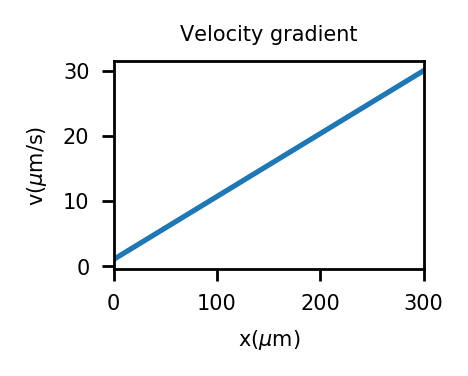

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(1.6,1.1),dpi=250)


mysize=5
posp=zeros((2,N))
posp[0] = linspace(0,L,N)
posp[1] = L/2

mysize=6
axes.set_title('Velocity gradient',fontsize=mysize)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('v($\mu$m/s)',fontsize=mysize)
axes.tick_params(labelsize=mysize)
axes.set_xlim(right=L,left=0)

vi=vprofile(posp,vgrad)
axes.plot(posp[0],vi)

plt.show()

# Simulation:

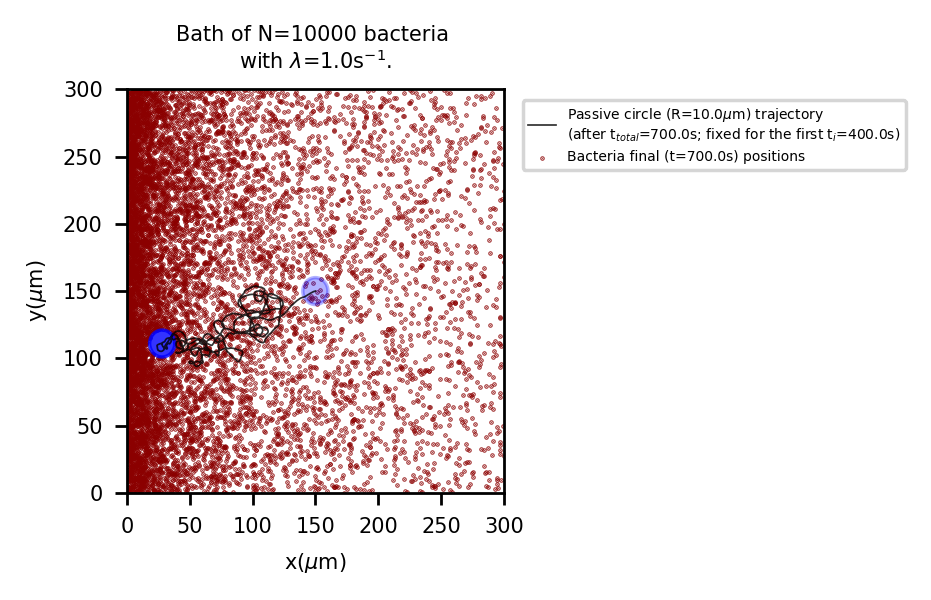

In [110]:
cells = Bacteria(N, v0, lam)
#cells.distribute(L)
cells.distribute_emptycircle(L,R)

sphere = Passive(R)
#sphere.distribute(L)
sphere.center(L)

#Total steps:
steps = 7000
#Steps before releasing the circle:
steps_fixed=4000


#-------------------------------------------------------------------------------
# plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3.9,2.5),dpi=250)
mysize=6
xlim(right=L,left=0)
ylim(top=L,bottom=0)
axes.set_xlabel('x($\mu$m)',fontsize=mysize)
axes.set_ylabel('y($\mu$m)',fontsize=mysize)
axes.set_title('Bath of N=' + str(N) + ' bacteria \n'
               'with $\lambda$=' + str(lam) + 's$^{-1}$.'
               ,fontsize=mysize)

#-------------------------------------------------------------------------------
circle = Circle((sphere.pos[0],sphere.pos[1]), radius=R,color='blue', alpha=0.3)
axes.add_patch(circle)


results_sx=zeros((steps))
results_sy=zeros((steps))
results_cx=np.zeros([steps,N])
results_cy=np.zeros([steps,N])

fix=True

for i in range(steps):
    
    if i>steps_fixed: fix=False
    
    sphere_v,sphere_dir,cells_v,cells_dir=interaction(cells,sphere,fix)
    cells.evolve(dt,cells_v,cells_dir)
    sphere.evolve(dt,sphere_v,sphere_dir)

    
    # we save the results to animate later
    results_cx[i,:]=cells.pos[0]
    results_cy[i,:]=cells.pos[1]
    results_sx[i]=sphere.pos[0]
    results_sy[i]=sphere.pos[1]
    
    print (i, end="\r")
    
    
plot(results_sx,results_sy,color='black',linewidth=0.5,alpha=0.8,label='Passive circle (R='+ str(R) + '$\mu$m) trajectory \n'
    '(after t$_{total}$='+ str(steps*dt) + 's; fixed for the first t$_i$='+ str(steps_fixed*dt) + 's)')
scatter(cells.pos[0],cells.pos[1],s=0.1,color='darkred',alpha=0.8,label='Bacteria final (t=' + str(steps*dt) + 's) positions' )

circle = Circle((sphere.pos[0],sphere.pos[1]), radius=R,color='blue', alpha=0.8)
axes.add_patch(circle)

axes.tick_params(labelsize=mysize)
legend(fontsize=mysize-2,loc=(1.05,0.8))

fig.tight_layout()

plt.savefig('/Users/work/Desktop/Passive_bathgradient.pdf')


## To make a video:

Animation movie is 107148755 bytes, exceeding the limit of 20971520.0. If you're sure you want a large animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB).


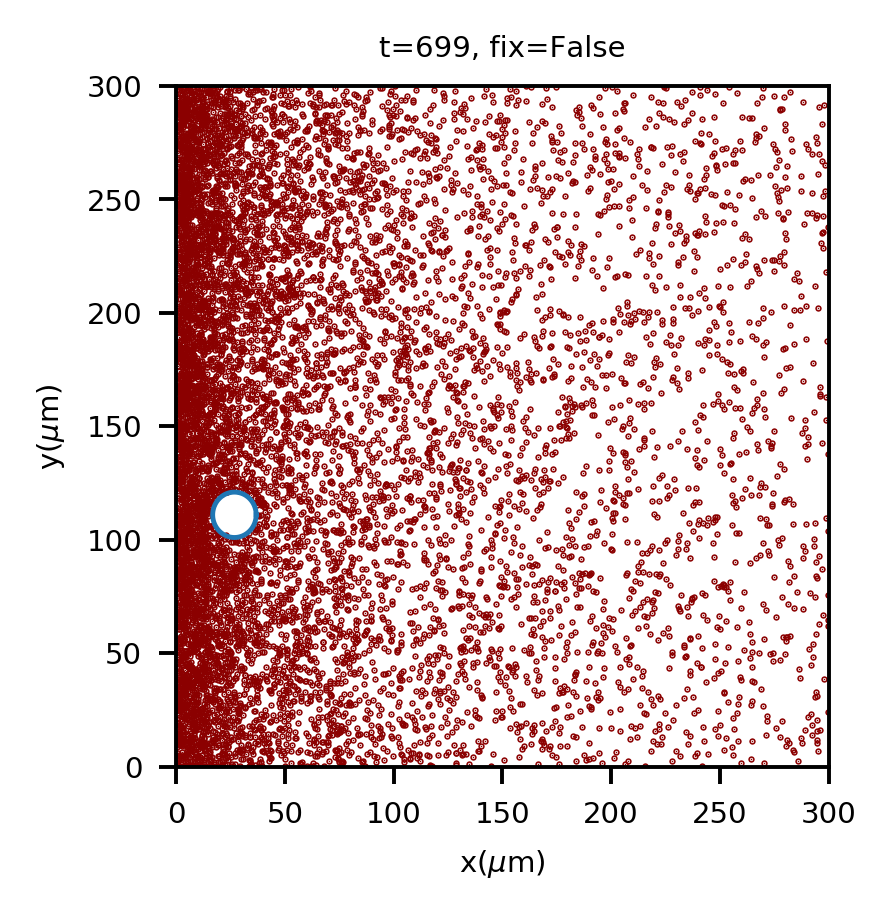

In [115]:
from matplotlib import animation
from IPython.display import HTML

fr_ps=np.int(1./dt)



#interval between animated frames:
df=10

# Speed up the video:
speed=10./df #/10.

fig = plt.figure(figsize=(2.65,2.6),dpi=350)
ax = plt.axes(xlim=(0, L), ylim=(0, L)) 
scat = ax.scatter([], [], s=0.1, color='darkred')

line, = ax.plot([], [], lw=1) 

#plt.title( 'Particles with $v_0$=' + str(v0) + ' $\mu$m/s, a probability of tumbling \n'
#            '$P_t=$' + str(p_s) + ' $s^{-1}$ (video speed ' + str(speed) + 'x)', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
ax.tick_params(labelsize=mysize)
fig.tight_layout()


def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

transp_cellsxy=np.transpose([results_cx, results_cy])
transp_spherexy=np.transpose([results_sx, results_sy])

fixan=True




# animation function 
def animate(i): 
    
    
    fixan = True if (i*df)<steps_fixed else False 

    
    scat.set_offsets(transp_cellsxy[:,i*df])
    theta = np.linspace(0, 2*pi, 100)
    r=R
    x=results_sx[i*df]+r*cos(theta)
    y=results_sy[i*df]+r*sin(theta)

    
    line.set_data(x, y)
    ax.set_title('t=' + str(int((i*df)*dt)) + ', fix=' + str(fixan),fontsize=mysize)
    

    
    print (i, end="\r")


    return scat, line,
    
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=int(steps/df), interval=100/speed, blit=True) 

HTML(anim.to_html5_video())

In [116]:
anim.save('Passive_bathgradient_fixed_beggining_8.mp4', writer = 'ffmpeg')#, fps = speed*fr_ps) 